In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F

import cv2
import albumentations as albu

import os
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


이미지 파일은 Images파일과 masks파일로 이루어져있습니다.
각각 대응되는 image파일과 masks 파일은 서로 같은 이름으로 되어있으며
train,test파일은 따로 분리 되어있지않아 train_test_split으로 분리해주었습니다.

In [4]:
route = '/content/drive/MyDrive/dataset/Water Bodies Dataset/' # image파일과 masks파일이 넣어져있는 경로

In [26]:
image_folder=os.path.join(route,'Images') # 이미지 폴더 위치
mask_folder=os.path.join(route,'Masks') # 마스크 폴더 위치
images=os.listdir(image_folder) #이미지 폴더에서 추출해낸 이미지 이름들 image와 masks는 서로 대응되는 이름이 같으므로 따로 추출할 필요가 없습니다.
train_image,test_image=train_test_split(images,test_size=0.2,random_state=42) #train,test분리

In [13]:
class dataset(torch.utils.data.Dataset):
  def __init__(self,dir,image_folder,mask_folder,transforms=None):
    self.dir=dir
    self.image_folder=image_folder
    self.mask_folder=mask_folder
    self.transforms=transforms
  def __len__(self):
    return len(self.dir)

  def __getitem__(self,idx):
    image_path=os.path.join(self.image_folder,self.dir[idx])
    mask_path=os.path.join(self.mask_folder,self.dir[idx])
    image=cv2.imread(image_path)
    image=np.array(image,dtype=np.float32)/225.0
    mask=cv2.imread(mask_path,0)
    mask=np.array(mask,dtype=np.float32)/255.0
    if self.transforms:
      augmented=self.transforms(image=image,mask=mask)
      image=augmented['image']
      mask=augmented['mask']
    image=torch.from_numpy(image).permute(2,0,1)
    mask=torch.from_numpy(mask).unsqueeze(0)

    return image,mask

In [27]:
import albumentations as A
transform=A.Compose([A.Resize(224,224)])
trainset=dataset(train_image,image_folder,mask_folder,transform)
testset=dataset(test_image,image_folder,mask_folder,transform)

In [28]:
trainloader=DataLoader(trainset,batch_size=32,num_workers=0,shuffle=True)
testloader=DataLoader(testset,batch_size=32,num_workers=0,shuffle=True)

In [29]:
from torchvision import models
base_model = models.resnet18(pretrained=True)
base_layers = list(base_model.children())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [31]:
model=UNet(n_class=1).to(device)
epochs=1
criterion=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
from tqdm import tqdm

In [32]:
for epoch in range(epochs):
  model.train()
  for image,mask in tqdm(trainloader):
    image,mask=image.to(device),mask.to(device)
    optimizer.zero_grad()
    pred=model(image)
    loss=criterion(pred,mask)
    loss.backward()
    optimizer.step()
  print(print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item())))




100%|██████████| 71/71 [01:02<00:00,  1.14it/s]


Epoch: 1 - Loss: 0.327976
None


In [33]:
torch.save(model,'pratice.pt')

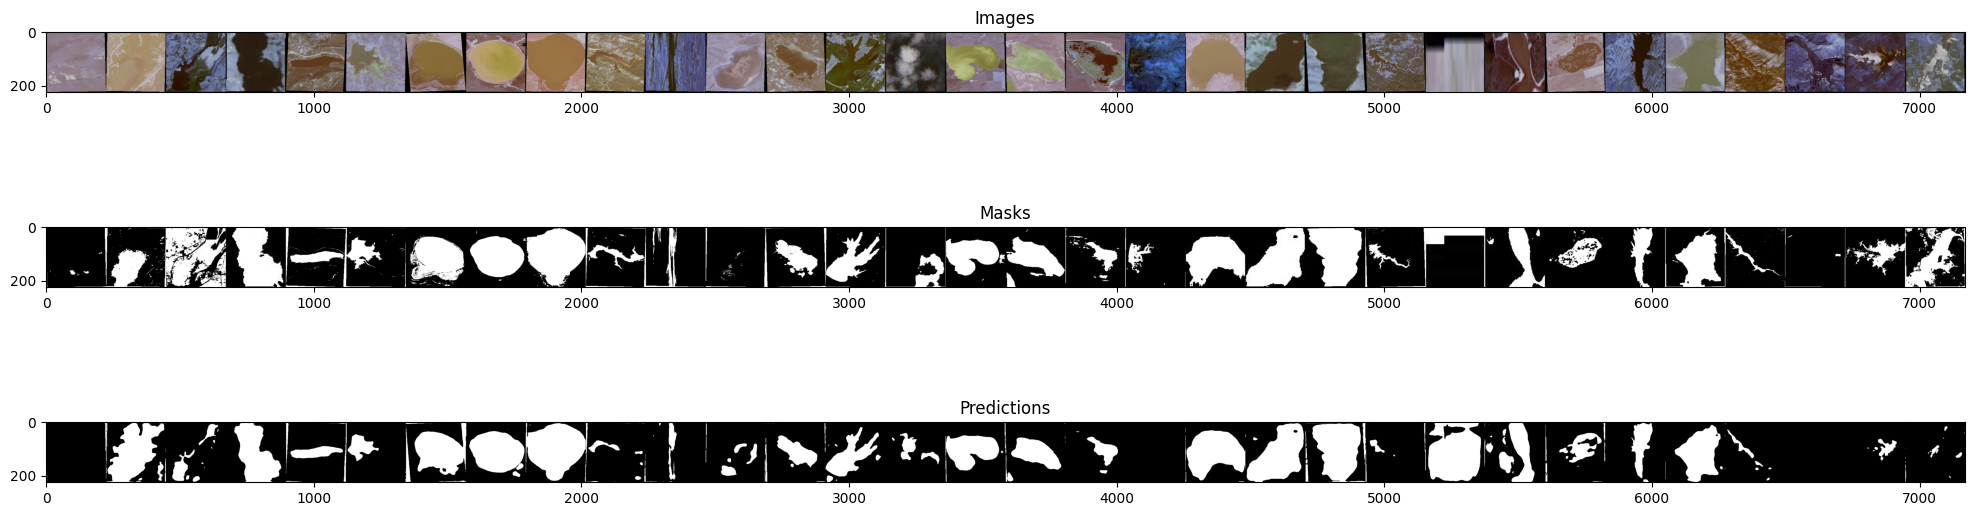

In [35]:
images, masks = next(iter(testloader))
with torch.no_grad():
    model.eval()
    pred = model(images.to(device)).cpu().detach()
    pred = pred > 0.5
def display_batch(images, masks, pred):
    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.numpy()
    masks = masks.numpy()
    pred = pred.numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap= 'gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap= 'gray')
    ax[2].set_title('Predictions')
display_batch(images, masks, pred)